In [45]:
import numpy as np
from timeit import default_timer as timer
### Simulation variables
h=4 # radius of particle
n=10 # number of particles in the cubic lattice
D=2 # number of dimensions
L=5 # length of cube
steps=20000
rho0=1
c2=1
gamma=7
H=.001
sg=h/4

### Dependant variables
N=n**D # total number of particles for now started in a cibic lattice
V=L**D/N
ConstDensKern=945/(64*np.pi*h**9)

A=1/(2*np.pi*sg**2) #normalisation constant

In [46]:
def Initialize2D(): # initialize 2D with a cubic lattice.
    x=np.zeros([steps,D,N],dtype=float)
    v=np.zeros([steps,D,N],dtype=float)
    rho=np.ones([steps,N],dtype=float)
    P=np.ones([steps,N],dtype=float)
    a=np.ones([N],dtype=float)
    for i in range(n):
        for j in range(n):
            x[0,0,n*i+j]=i/n*L
            x[0,1,n*i+j]=j/n*L
    x[0,:,:]=x[0,:,:]+0.5*L/10
    x[0,1,:]=x[0,1,:]+1
    #v[0,:,:]=.001*(-1+2*np.random.rand(D,N))
    v[0,1,:]=v[0,1,:]-2
    P[0,:]=rho0*c2/gamma*((rho[0,:]/rho0)**gamma-1)
    return x,v,rho,P,a

def DistanceMatrix(x):
    """Creates a matrix that stores vectorial distance between particles,
    each row is a particle and each column is the distance to that particle e.g. |Xi-Xj|"""
    Dist=np.zeros([N,N],dtype=float)
    for d in range (D):
        X,Y=np.meshgrid(x[d,:],x[d,:])
        Dist=Dist+(X-Y)**2
    Dist=np.sqrt(Dist)
    Dist=Dist[~np.eye(Dist.shape[0],dtype=bool)].reshape(Dist.shape[0],-1) #kills the values on the diagonal to avoid self interaction.
    return Dist

def DifferenceVector(x):
    """Creates a matrix that stores vectorial difference between particles,
    each row is a particle and each column is the distance to that particle e.g. |Xi-Xj|"""
    Diff=np.zeros([D,N,N-1],dtype=float)
    #print(Diff)
    for d in range (D):
        X,Y=np.meshgrid(x[d,:],x[d,:])
        Dif=(X-Y)
        Dif=Dif[~np.eye(Dif.shape[0],dtype=bool)].reshape(Dif.shape[0],-1) #kills the values on the diagonal to avoid self interaction.
        Diff[d,:,:]=Dif
        #print(Diff)    
    return Diff

def RhoMatrixj(x):
    """Creates a matrix that stores vectorial distance between particles,
    each row is a particle and each column is the distance to that particle e.g. |Xi-Xj|"""
    Dist=np.zeros([N,N],dtype=float)
    X,Y=np.meshgrid(x,x)
    Dist=Dist+X
    Dist=Dist[~np.eye(Dist.shape[0],dtype=bool)].reshape(Dist.shape[0],-1) #kills the values on the diagonal to avoid self interaction.
    return Dist

def RhoMatrixi(x):
    """Creates a matrix that stores vectorial distance between particles,
    each row is a particle and each column is the distance to that particle e.g. |Xi-Xj|"""
    Dist=np.zeros([N,N],dtype=float)
    X,Y=np.meshgrid(x,x)
    Dist=Dist+Y
    Dist=Dist[~np.eye(Dist.shape[0],dtype=bool)].reshape(Dist.shape[0],-1) #kills the values on the diagonal to avoid self interaction.
    return Dist

def InRangeKernel(x,rang,func0):
    """Sets the values that are out of range (rang) for the Kernel equal to 
    a value where that function is equal to 0 (func0)"""
    x[x > rang] = func0
    return x
    
def DivDensityKernel(ConstDensKern,x,h):            #density kernel Jos kernel
    x=DistanceMatrix(x)
    x=InRangeKernel(x,h,h)
    return ConstDensKern*(h**2-x**2)**2

def gradW(r,sg):                                  #gradient gaussian Kernel
    return -r/(sg**2)*W(r,sg)

def W(r,sg):                                      #gaussian Kernel
    return A*np.exp(-r**2/(2*sg**2))

def GradWtot(x,sg,N):
    p=DifferenceVector(x)
    q=DistanceMatrix(x)
    ztotal=np.zeros([2,N,N-1],dtype=float)
    ztotal[0,:,:]=gradW(q,sg)*p[0,:,:]/q
    ztotal[1,:,:]=gradW(q,sg)*p[1,:,:]/q
    return ztotal

def RhoStep(x,v,rho,P,step):
    posV=DifferenceVector(x[step,:,:])
    velV=DifferenceVector(v[step,:,:])
    posM=DistanceMatrix(x[step,:,:])
    velM=DistanceMatrix(v[step,:,:])
    zz=GradWtot(x[step,:,:],sg,N)
    k=np.sum(zz*velV, axis=0)
    kk=np.sum(RhoMatrixj(rho[step,:])*k,axis=1)*V
    rho[step+1,:]=rho[step,:]+kk*H
    
def VelStep(x,v,rho,P,step):
    rhos=rho[step,:]
    press=P[step,:]
    xs=x[step,1,:]
    PotW=(xs<sg).astype(np.float)
    zz=GradWtot(x[step,:,:],sg,N)
    proterm=RhoMatrixj(rhos)*(RhoMatrixi(press)/(RhoMatrixi(rhos)**2)+RhoMatrixj(press)/(RhoMatrixj(rhos)**2)+PIij(x,v,rho,P,step))
    vchange=np.zeros([2,N,N-1],dtype=float)
    vchange[0,:,:]=-V*proterm*zz[0,:,:]
    vchange[1,:,:]=-V*proterm*zz[1,:,:]
    kk=np.sum(vchange,axis=2)
    xx=x
    v[step+1,:,:]=v[step,:,:]-kk*H
    
    DivU=Ulj2(xs,sg)
    argo=PotW* DivU * xs * H
    v[step+1,1,:]=v[step+1,1,:]-PotW* DivU * xs * H 

def PresStep(x,v,rho,P,step):
    P[step+1,:]=rho0*c2/gamma*((rho[step,:]/rho0)**gamma-1)
    
def PosStep(x,v,rho,P,step):
    x[step+1,:,:]=x[step,:,:]+v[step,:,:]*H
    
def PIij(x,v,rho,P,step):
    rhos=rho[step,:]
    posM=DistanceMatrix(x[step,:,:])
    posV=DifferenceVector(x[step,:,:])
    velV=DifferenceVector(v[step,:,:])
    aa=np.sum(posV*velV,axis=0)<0
    bb=aa.astype(np.float)
    zzz=-8*h/(RhoMatrixi(rhos)+RhoMatrixj(rhos))*np.sum(posV*velV,axis=0)*bb/(posM+.01*h**2)
    return zzz

def Ulj2(r,sg):
    """Ulj2() calculates the dimensionless force from the dimensionless radius between two particles."""
    return 4/(sg**2)*(-12*(r/sg)**-14+6*(r/sg)**-8)         # F=-dU/dr*1/r


def InitializeDisc(x0,y0,r,R,q):
    N=r*q+1
    x=np.zeros([2,N],dtype=float)
    x[:,0]=[x0,y0]
    for i in range (N-1):
        x[0,i+1]=(i//q+1)*R/r*np.sin(2*np.pi*i/q)+x0
        x[1,i+1]=(i//q+1)*R/r*np.cos(2*np.pi*i/q)+y0
    return N,x

def ExtentAnnulus(x0,y0,r,R,q,Nc,x,r0):
    Ntot=Nc+r*q
    N=r*q
    x=np.concatenate((x, np.zeros([2,N],dtype=float)),axis=1)
    for i in range (N):
        x[0,Nc+i]=(r0+(i//q)*R/r)*np.sin(2*np.pi*i/q)+x0
        x[1,Nc+i]=(r0+(i//q)*R/r)*np.cos(2*np.pi*i/q)+y0
    return Ntot,x



def Initialize2Dc(): # initialize 2D with a cubic lattice.
    xc=1
    yc=1
    N,y=InitializeDisc(xc,yc,1,0.5,6)
    N,y=ExtentAnnulus(xc,yc,2,1,8,N,y,1)
    N,y=ExtentAnnulus(xc,yc,2,1,16,N,y,1.5)
    x=np.zeros([steps,D,N],dtype=float)
    v=np.zeros([steps,D,N],dtype=float)
    rho=np.ones([steps,N],dtype=float)
    P=np.ones([steps,N],dtype=float)
    a=np.ones([N],dtype=float)
    
    x[0,:,:]=y
    x[0,1,:]=x[0,1,:]+1
    #v[0,:,:]=.001*(-1+2*np.random.rand(D,N))
    v[0,1,:]=v[0,1,:]-2
    P[0,:]=rho0*c2/gamma*((rho[0,:]/rho0)**gamma-1)
    return N,x,v,rho,P,a

def Pot(r):
    """Returns the Lennard-Jones potential of a radius r."""
    return 4*(r**-12-r**-6)

def InRangePot(x,ii):
    xz=x[ii,1,:]
    PotW=(xz<sg).astype(np.float)
    PP=Pot(xz)
    return np.sum(PP*PotW)

def KinEn(v,rho,i):
    """KinEn() calculates the total kinetic energy of the velocity matrix at step i."""
    return .5*np.sum(np.square(v[i,0,:]))+.5*np.sum(np.square(v[i,1,:]))

def EnergyCalc(x,v,rho,steps):
    PotE=np.zeros([steps],dtype=float)
    KinE=np.zeros([steps],dtype=float)
    TotE=np.zeros([steps],dtype=float)
    for ii in range(steps):
        KinE[ii]=KinEn(v,rho,ii)
        PotE[ii]=InRangePot(x,ii)+.5*np.sum(W(DistanceMatrix(x[ii,:,:]),sg))
        TotE[ii]=KinE[ii]+PotE[ii]
    return PotE,KinE,TotE

In [47]:
t1 = timer()
x,v,rho,P,a=Initialize2D()

for i in range(steps-1):
    step=i
    i2=int(i/2)                                 # Pot&Kin only updated after a whole Leapfrog step
    if i%2==0:
        x[i+1,:,:]=x[i,:,:]                     # Leapfrog 1/2 step, use old position 
        VelStep(x,v,rho,P,step)
        rho[i+1,:]=rho[i,:]
        P[i+1,:]=P[i,:]
            
    else:
        RhoStep(x,v,rho,P,step)
        PosStep(x,v,rho,P,step)          # calculate new position, from old position + velocity * h  
        PresStep(x,v,rho,P,step)
        v[i+1,:,:] = v[i,:,:]                   # use old velocity                                                              
    if (i+2)/steps*100%10==0:
        print((i+2)/steps*100,'%')              # print the progress
print('Calculating energies...')
PotE,KinE,TotE=EnergyCalc(x,v,rho,steps)
t2=timer()
print('Time in seconds:')
print(t2-t1)
print('Simulation finished')

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Calculating energies...
Time in seconds:
53.905333224684
Simulation finished


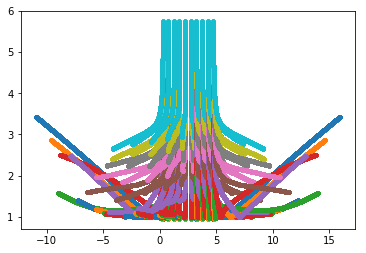

<Figure size 432x288 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt
for i in range(N):
    plt.plot(x[:,0,i],x[:,1,i],linestyle="",marker=".")
plt.show()
plt.savefig('trajectories.eps')

In [78]:
for i in range(N):
        plt.plot(x[np.arange(0,steps,int(steps/10)),0,i],x[np.arange(0,steps,int(steps/10)),1,i],linestyle="-",marker=".")
plt.show()
plt.savefig('trajectories.eps')

IndexError: index 2400 is out of bounds for axis 0 with size 2000

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

def plot_for_offset(power, y_max):
    # Data for plotting
    t = x[power,0,:]
    s = x[power,1,:]

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(t, s,'.')
    ax.grid()

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_ylim(0, 6)
    ax.set_xlim(-5,10)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':3.0, 'quantizer':'nq'}
imageio.mimsave('./powers20short.gif', [plot_for_offset(i*100, 100) for i in range(int(steps/100))], fps=3)
plt.close('all')

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [81]:
print(np.arange(steps).shape)

(2000,)


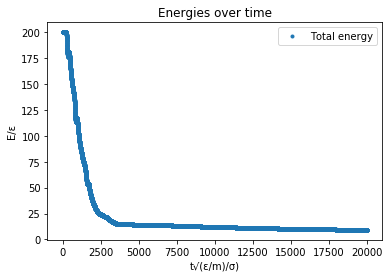

In [50]:
#Plot energies
import matplotlib.pyplot as plt
#plt.plot(np.arange(steps),TotE,linestyle="",marker=".")
plt.plot(np.arange(steps),KinE,linestyle="",marker=".")
#plt.plot(np.arange(steps),PotE,linestyle="",marker=".")
plt.legend(['Total energy', 'Kinetic energy', 'Potential energy'])
plt.xlabel('t\u221A(\u03B5/m)/\u03C3)')
plt.ylabel('E/\u03B5')
plt.title('Energies over time')
plt.savefig('energietimegas.png')
plt.show()

In [24]:
np.min(DistanceMatrix(x[900,:,:]))

0.29167585828170223